# Introduction



---



---



In this notebook, we will implement the following tests for the LINEAR MADDEN PROBLEM:


a) For each epsilon:

i) Until mesh convergence

- Physical solve based on current mesh
- Compute the L2 and H1 errors in the physical solution
- Compute Hessian M based on the current physical solution and mesh, take $\alpha_{hat} = \epsilon^{-3/4}$ (for $m=0$) or $\alpha_{hat} = \epsilon^{-5/4}$ (for $m=1$)
- Perform a mesh solve
- Continuation in $u$ and $x$

ii) Continuation in $u$ and $x$

b) Compare errors, solutions, etc


# Where Do These Scalings Come From?


---



---



I will work it out in the L2 case and leave the H1 case for the reader (lol).


## Step 1 - From my "Exploring_M_and_Epsilon_Relationship" notebook:





- This notebook shows us that the L1 norm of $|u''|$ behaves like $\frac{1}{\epsilon}.$ Thus, $|u''|$ behaves like $\frac{1}{\epsilon^2}.$

- To see this, note that the L1 norm of $|u''|$ is $$ \text{L1 Norm} = \text{width} \times |u''|  \approx \frac{1}{\epsilon}.$$
$$ (\text{width} = \epsilon)  \times |u''|  \approx \frac{1}{\epsilon}.$$
For this to be true, $$ | u'' | \approx \frac{1}{\epsilon^2}.$$


## Step 2 - The Scaling on $|u''|$ in $M$





In the L2 case, I formulate $M$ as $M = ( 1 + \frac{1}{\alpha} |u''| )^{4/5}.$ We want the integral of $M$ to be $O(1).$ Thus, we want
$$ \text{width} = \epsilon \times M \approx 1$$
or
$$ M \approx \epsilon^{-1}.$$

Based on Step 1, we have

$$ \left(\frac{1}{\alpha} |u''| \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right)^{4/5} \approx \epsilon^{-1} $$
$$ \left(\frac{1}{\alpha} \epsilon^{-2} \right) \approx \epsilon^{-5/4} $$
$$ \left(\frac{1}{\alpha}\right) \approx \epsilon^{-5/4} \epsilon^{2} = \epsilon^{3/4}.$$

Thus, we take

$$ \alpha = \text{constant} \times \epsilon^{-3/4}.$$

# Results and Comments


---



---

- Results look good!

- Mesh solve is in CG1 and physical solve is in CG4. When I set these both to be in CG2 my MP-Iteration seemed to oversolve itself and endup with a horrible mesh. I am not sure why changing the function space fixed this issue.

- Going forward, would like to add in another MP-Iteration stopping criteria where, after the physical solve, I compute the residual of the mesh problem using my current solution x and the updated physical solution u(x) plugged into the mesh density function M. - I do not yet have this desired mesh residual stopping criteria worked into the MP_Iteration yet. The current residual calculation does not seem very informative.

- Following up on the last point, with more experimentation I switched to mesh_tol = (1/10)*epsilon for the norm(mesh difference) as stopping criteria for the MP-Iteration.

In [1]:
# install firedrake

# hide output
%%capture

try:
    from firedrake import *
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    from firedrake import *

In [2]:
# Code in this cell makes plots appear an appropriate size and resolution in the browser window

%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (11, 6)

In [3]:
# import firedrake tools

from firedrake import *
import numpy as np
import matplotlib.pyplot as plt # firedrake makes use of matplotlib tools
from firedrake.pyplot import tripcolor, tricontour, triplot #firedrake plotting
from IPython.display import display
from mpl_toolkits import mplot3d



# Setup

In [4]:
# SETUP

# Mesh and space
N = 50
xi_mesh = UnitIntervalMesh(N)
V_mesh = FunctionSpace(xi_mesh, 'CG', 1)
V_phys = FunctionSpace(xi_mesh, "CG", 4)
V_residual = FunctionSpace(xi_mesh, "R", 0)
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
perm_x =  np.argsort(x.dat.data[:])



# Solver paramaters


newton_params = {
        'snes_type': 'newtonls',
        # 'snes_monitor': None,
        # "snes_converged_reason": None,
        'ksp_type': 'preonly',
        'snes_linesearch_type': 'l2',
        # 'snes_linesearch_monitor': None,
        'snes_linesearch_damping': 0.5,
        'pc_type' : 'lu',
        'snes_rtol': 1e-8,
        'snes_stol': 1e-8,
        'snes_max_it': 100,
}


lu_params = {
    'snes_type': 'ksponly',
    # 'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'preonly',
    'pc_type': 'lu',
}

mesh_params = {
    'snes_type': 'ksponly',
    'snes_monitor': None,
    'mat_type': 'aij',
    'ksp_type': 'richardson',
    'ksp_richardson_scale': 0.5,
    'pc_type': 'lu',
}

# Numerical Test



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.1
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.5773502691896256
norm(u) =  1.0408329997330663



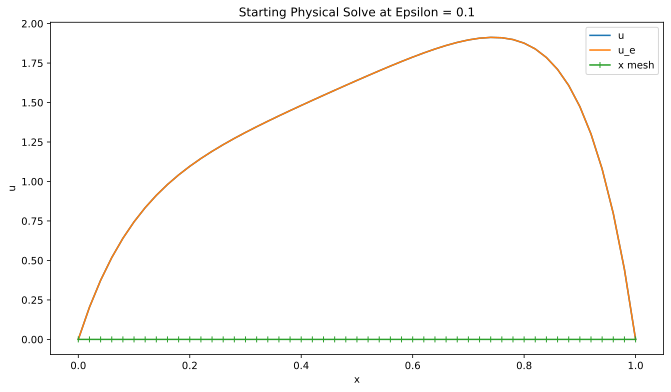



  0 SNES Function norm 1.683803766101e+00
  1 SNES Function norm 1.284640324219e-05
  0 SNES Function norm 6.961005565268e-01
  1 SNES Function norm 5.310825779404e-06
  0 SNES Function norm 3.203230336790e-01
  1 SNES Function norm 2.443870803279e-06
  0 SNES Function norm 2.007116629768e-01
  1 SNES Function norm 1.531308464808e-06
  0 SNES Function norm 1.554771596982e-01
  1 SNES Function norm 1.186196590424e-06
  0 SNES Function norm 1.238412551297e-01
  1 SNES Function norm 9.448337943246e-07
  0 SNES Function norm 9.658597989100e-02
  1 SNES Function norm 7.368925465667e-07
  0 SNES Function norm 7.358513848260e-02
  1 SNES Function norm 5.614100525798e-07
  0 SNES Function norm 5.493584914871e-02
  1 SNES Function norm 4.191272677700e-07
  0 SNES Function norm 4.027098877753e-02
  1 SNES Function norm 3.072432611296e-07
  0 SNES Function norm 2.901490634392e-02
  1 SNES Function norm 2.213661677328e-07
  0 SNES Function norm 2.055825117569e-02
  1 SNES Function norm 1.5684700

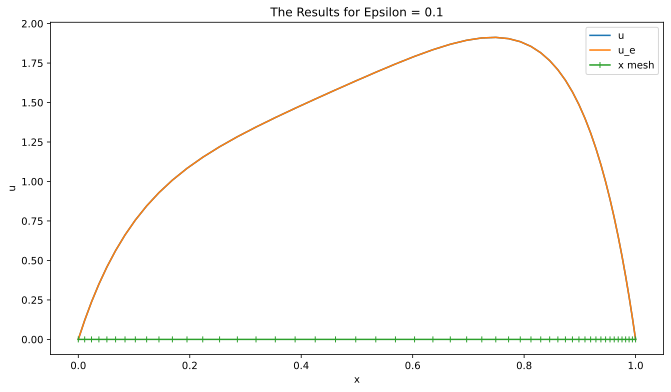



Epsilon continuation checks
norm(x) =  0.6721124292085078
norm(u) =  1.3211492045830497



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.07500000000000001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6721124292085078
norm(u) =  1.3211492045830497



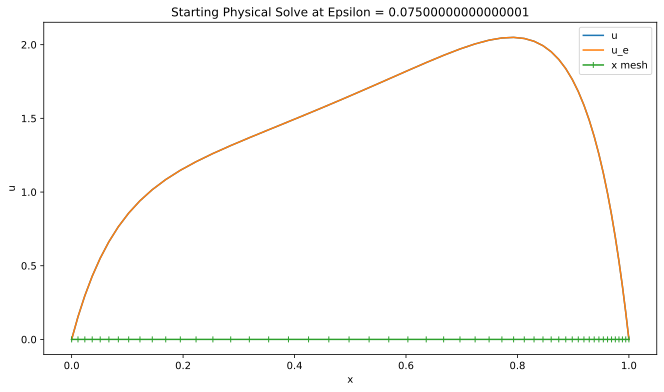



  0 SNES Function norm 2.819284211605e-01
  1 SNES Function norm 2.150943156623e-06
  0 SNES Function norm 1.398901515919e-01
  1 SNES Function norm 1.067277158063e-06
  0 SNES Function norm 8.533689575080e-02
  1 SNES Function norm 6.510688447562e-07
  0 SNES Function norm 6.100420653304e-02
  1 SNES Function norm 4.654251597672e-07
  0 SNES Function norm 4.561562218603e-02
  1 SNES Function norm 3.480195797291e-07
  0 SNES Function norm 3.396384805269e-02
  1 SNES Function norm 2.591235972410e-07
  0 SNES Function norm 2.495633681785e-02
  1 SNES Function norm 1.904017392207e-07
  0 SNES Function norm 1.811338847025e-02
  1 SNES Function norm 1.381941865845e-07
  0 SNES Function norm 1.299536050882e-02
  1 SNES Function norm 9.914673222643e-08
  0 SNES Function norm 9.227768015521e-03
  1 SNES Function norm 7.040228221178e-08
  0 SNES Function norm 6.499463974179e-03
  1 SNES Function norm 4.958697385047e-08
  0 SNES Function norm 4.524301939315e-03
  1 SNES Function norm 3.4517684

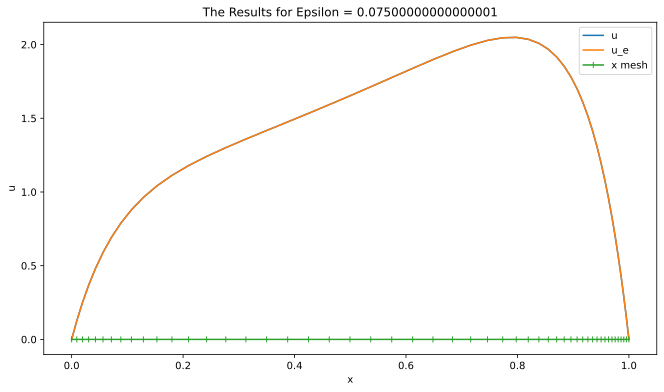



Epsilon continuation checks
norm(x) =  0.6819787123102145
norm(u) =  1.3905916787893846



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.05625000000000001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6819787123102145
norm(u) =  1.3905916787893846



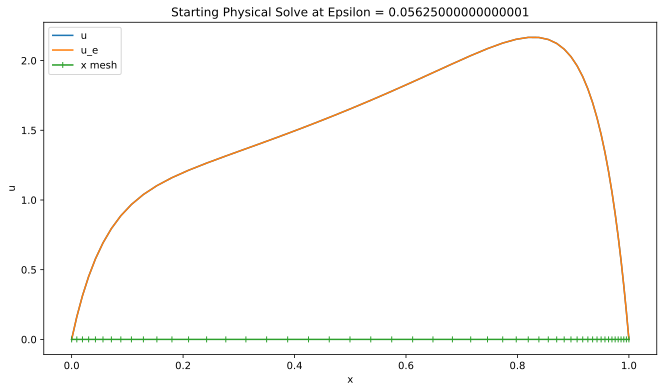



  0 SNES Function norm 3.448829878471e-01
  1 SNES Function norm 2.631248383833e-06
  0 SNES Function norm 1.810456077966e-01
  1 SNES Function norm 1.381268369924e-06
  0 SNES Function norm 1.144637277120e-01
  1 SNES Function norm 8.732889371441e-07
  0 SNES Function norm 8.442703491019e-02
  1 SNES Function norm 6.441271572627e-07
  0 SNES Function norm 6.604677237332e-02
  1 SNES Function norm 5.038968853720e-07
  0 SNES Function norm 5.194912514234e-02
  1 SNES Function norm 3.963403701364e-07
  0 SNES Function norm 4.033882418485e-02
  1 SNES Function norm 3.077608045734e-07
  0 SNES Function norm 3.075826467981e-02
  1 SNES Function norm 2.346669370616e-07
  0 SNES Function norm 2.299557057748e-02
  1 SNES Function norm 1.754422808805e-07
  0 SNES Function norm 1.685070022332e-02
  1 SNES Function norm 1.285606417983e-07
  0 SNES Function norm 1.210332724041e-02
  1 SNES Function norm 9.234105879262e-08
  0 SNES Function norm 8.523498801074e-03
  1 SNES Function norm 6.5029135

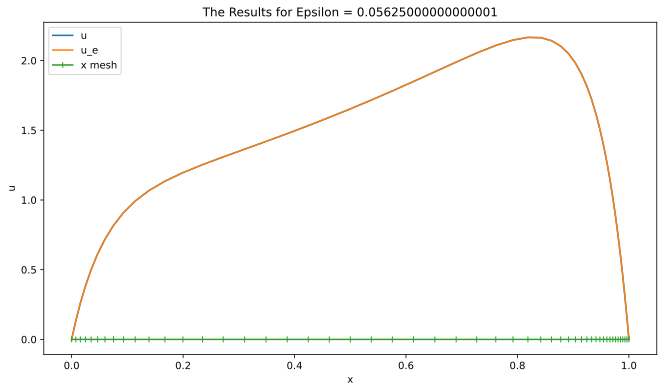



Epsilon continuation checks
norm(x) =  0.6898120700473803
norm(u) =  1.4448171724077417



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0421875
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6898120700473803
norm(u) =  1.4448171724077417



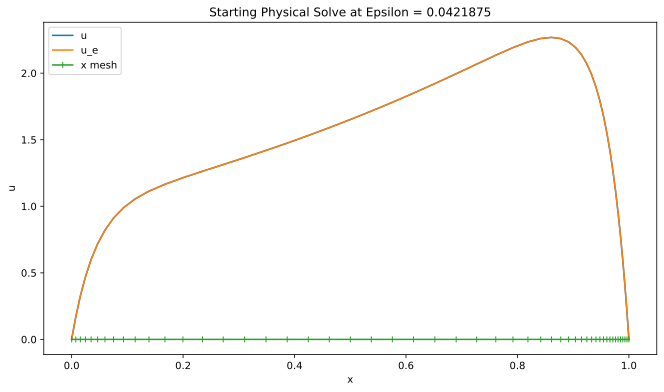



  0 SNES Function norm 4.043943129441e-01
  1 SNES Function norm 3.085283758730e-06
  0 SNES Function norm 2.251109903698e-01
  1 SNES Function norm 1.717460559822e-06
  0 SNES Function norm 1.496238433515e-01
  1 SNES Function norm 1.141539335012e-06
  0 SNES Function norm 1.156448067465e-01
  1 SNES Function norm 8.822998553368e-07
  0 SNES Function norm 9.601724769654e-02
  1 SNES Function norm 7.325534652864e-07
  0 SNES Function norm 8.076248104181e-02
  1 SNES Function norm 6.161688300675e-07
  0 SNES Function norm 6.702137320668e-02
  1 SNES Function norm 5.113324978614e-07
  0 SNES Function norm 5.425661681524e-02
  1 SNES Function norm 4.139451357926e-07
  0 SNES Function norm 4.212800107196e-02
  1 SNES Function norm 3.214111437423e-07
  0 SNES Function norm 3.174945511410e-02
  1 SNES Function norm 2.422291200111e-07
  0 SNES Function norm 2.326162517706e-02
  1 SNES Function norm 1.774721180852e-07
  0 SNES Function norm 1.659650346031e-02
  1 SNES Function norm 1.2662127

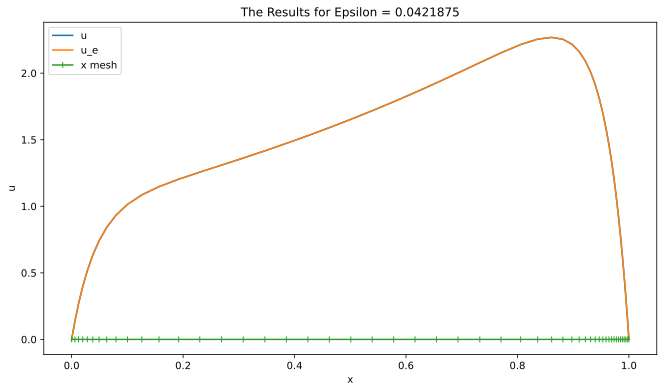



Epsilon continuation checks
norm(x) =  0.6964392526742713
norm(u) =  1.4866989469377399



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.031640625000000006
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.6964392526742713
norm(u) =  1.4866989469377399



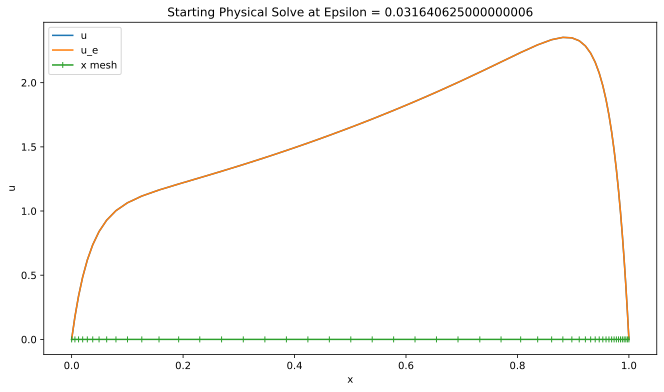



  0 SNES Function norm 4.701780782625e-01
  1 SNES Function norm 3.587174063321e-06
  0 SNES Function norm 2.798376783061e-01
  1 SNES Function norm 2.134992051993e-06
  0 SNES Function norm 1.938974778415e-01
  1 SNES Function norm 1.479320359839e-06
  0 SNES Function norm 1.550873961992e-01
  1 SNES Function norm 1.183222936622e-06
  0 SNES Function norm 1.355395403941e-01
  1 SNES Function norm 1.034084627842e-06
  0 SNES Function norm 1.213270008561e-01
  1 SNES Function norm 9.256515541829e-07
  0 SNES Function norm 1.068034110378e-01
  1 SNES Function norm 8.148453588505e-07
  0 SNES Function norm 9.088639091174e-02
  1 SNES Function norm 6.934081350583e-07
  0 SNES Function norm 7.440817290044e-02
  1 SNES Function norm 5.676893070018e-07
  0 SNES Function norm 5.826456788994e-02
  1 SNES Function norm 4.445233759141e-07
  0 SNES Function norm 4.398758048733e-02
  1 SNES Function norm 3.355986055296e-07
  0 SNES Function norm 3.213643943927e-02
  1 SNES Function norm 2.4518157

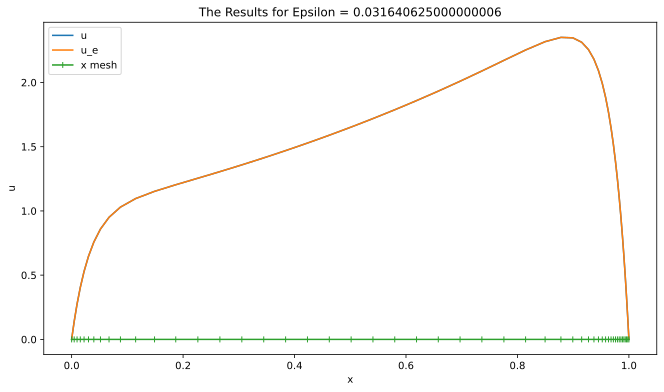



Epsilon continuation checks
norm(x) =  0.7019305715743066
norm(u) =  1.5190638845611708



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.023730468750000004
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7019305715743066
norm(u) =  1.5190638845611708



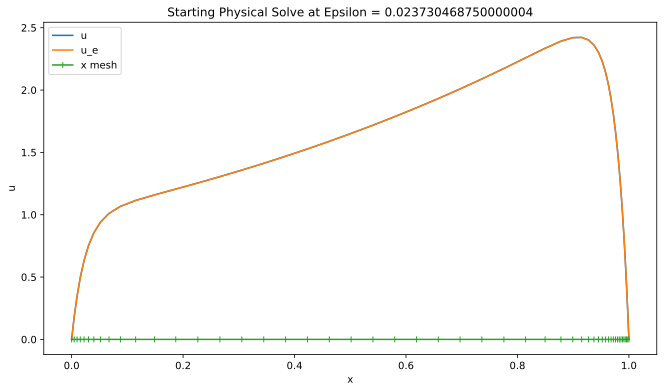



  0 SNES Function norm 5.455023808282e-01
  1 SNES Function norm 4.161852882086e-06
  0 SNES Function norm 3.491339901124e-01
  1 SNES Function norm 2.663680956005e-06
  0 SNES Function norm 2.502724049204e-01
  1 SNES Function norm 1.909426916001e-06
  0 SNES Function norm 2.036459479811e-01
  1 SNES Function norm 1.553695282649e-06
  0 SNES Function norm 1.849055759559e-01
  1 SNES Function norm 1.410717591078e-06
  0 SNES Function norm 1.753552195346e-01
  1 SNES Function norm 1.337854153471e-06
  0 SNES Function norm 1.639804394319e-01
  1 SNES Function norm 1.251071465013e-06
  0 SNES Function norm 1.474524002469e-01
  1 SNES Function norm 1.124972535470e-06
  0 SNES Function norm 1.266426760674e-01
  1 SNES Function norm 9.662069416491e-07
  0 SNES Function norm 1.036901554569e-01
  1 SNES Function norm 7.910931050220e-07
  0 SNES Function norm 8.075170036830e-02
  1 SNES Function norm 6.160865763128e-07
  0 SNES Function norm 6.048722288873e-02
  1 SNES Function norm 4.6148088

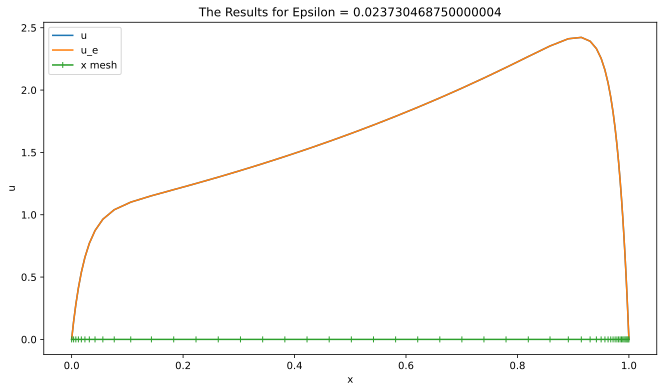



Epsilon continuation checks
norm(x) =  0.7063783914796496
norm(u) =  1.5440593692785023



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0177978515625
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7063783914796496
norm(u) =  1.5440593692785023



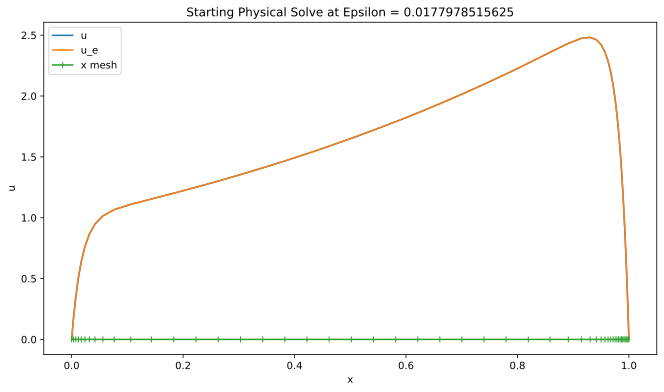



  0 SNES Function norm 6.305749069675e-01
  1 SNES Function norm 4.810904743375e-06
  0 SNES Function norm 4.351638318733e-01
  1 SNES Function norm 3.320036560975e-06
  0 SNES Function norm 3.213935274962e-01
  1 SNES Function norm 2.452038026900e-06
  0 SNES Function norm 2.620321210065e-01
  1 SNES Function norm 1.999146432928e-06
  0 SNES Function norm 2.431377656688e-01
  1 SNES Function norm 1.854993941864e-06
  0 SNES Function norm 2.425611231868e-01
  1 SNES Function norm 1.850594506488e-06
  0 SNES Function norm 2.407588046462e-01
  1 SNES Function norm 1.836843910477e-06
  0 SNES Function norm 2.282954094966e-01
  1 SNES Function norm 1.741755749878e-06
  0 SNES Function norm 2.044986310539e-01
  1 SNES Function norm 1.560200737426e-06
  0 SNES Function norm 1.744057556169e-01
  1 SNES Function norm 1.330610321262e-06
  0 SNES Function norm 1.421476402925e-01
  1 SNES Function norm 1.084500438168e-06
  0 SNES Function norm 1.103511236329e-01
  1 SNES Function norm 8.4191225

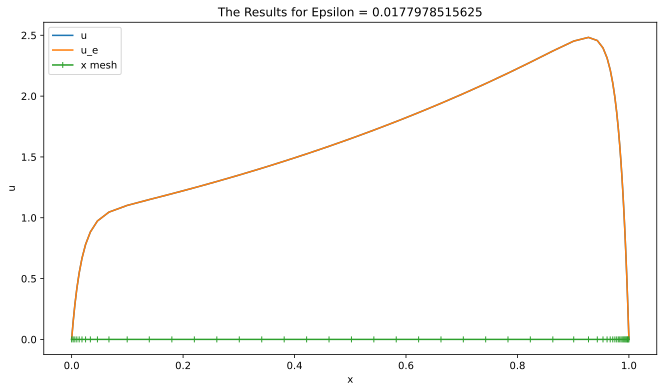



Epsilon continuation checks
norm(x) =  0.709922248066935
norm(u) =  1.5633276381476526



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.013348388671875001
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.709922248066935
norm(u) =  1.5633276381476526



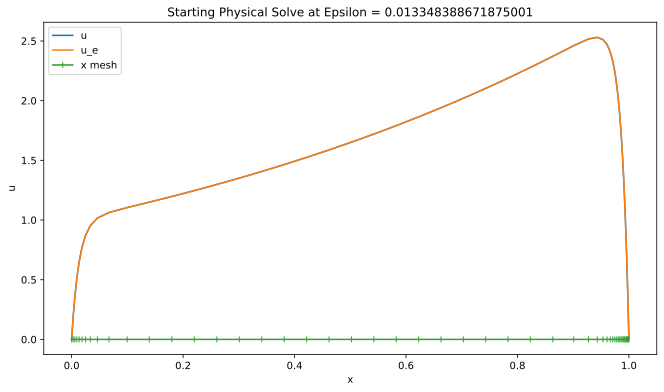



  0 SNES Function norm 7.250208338339e-01
  1 SNES Function norm 5.531469983984e-06
  0 SNES Function norm 5.363809635753e-01
  1 SNES Function norm 4.092261991826e-06
  0 SNES Function norm 4.084049948602e-01
  1 SNES Function norm 3.115882838545e-06
  0 SNES Function norm 3.316753200217e-01
  1 SNES Function norm 2.530481875179e-06
  0 SNES Function norm 3.076940476083e-01
  1 SNES Function norm 2.347519287441e-06
  0 SNES Function norm 3.176568204614e-01
  1 SNES Function norm 2.423529208365e-06
  0 SNES Function norm 3.332375210303e-01
  1 SNES Function norm 2.542400518649e-06
  0 SNES Function norm 3.356254031886e-01
  1 SNES Function norm 2.560618617220e-06
  0 SNES Function norm 3.184684511370e-01
  1 SNES Function norm 2.429721455627e-06
  0 SNES Function norm 2.838984716247e-01
  1 SNES Function norm 2.165973451114e-06
  0 SNES Function norm 2.389932529679e-01
  1 SNES Function norm 1.823373820485e-06
  0 SNES Function norm 1.915650686504e-01
  1 SNES Function norm 1.4615254

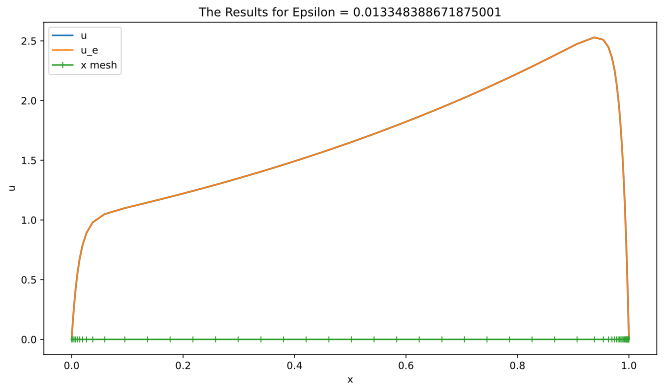



Epsilon continuation checks
norm(x) =  0.7126999657594018
norm(u) =  1.5781011308839514



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.01001129150390625
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7126999657594018
norm(u) =  1.5781011308839514



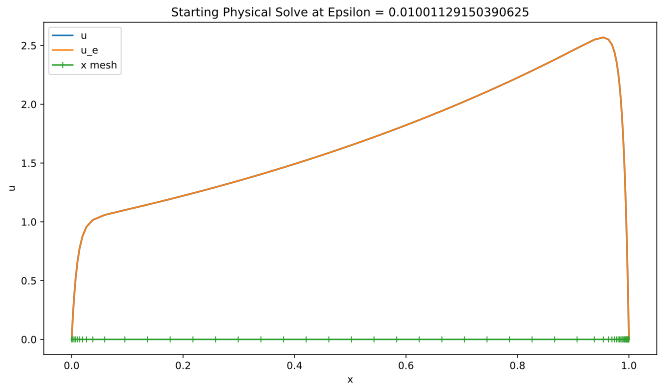



  0 SNES Function norm 8.319225476539e-01
  1 SNES Function norm 6.347065327105e-06
  0 SNES Function norm 6.527589838290e-01
  1 SNES Function norm 4.980155823155e-06
  0 SNES Function norm 5.110859040209e-01
  1 SNES Function norm 3.899275999109e-06
  0 SNES Function norm 4.138555205068e-01
  1 SNES Function norm 3.157467044428e-06
  0 SNES Function norm 3.798562927515e-01
  1 SNES Function norm 2.898073527214e-06
  0 SNES Function norm 3.983501874855e-01
  1 SNES Function norm 3.039170749399e-06
  0 SNES Function norm 4.305870522541e-01
  1 SNES Function norm 3.285118503522e-06
  0 SNES Function norm 4.496888883097e-01
  1 SNES Function norm 3.430853952340e-06
  0 SNES Function norm 4.509659275147e-01
  1 SNES Function norm 3.440596992760e-06
  0 SNES Function norm 4.279996667711e-01
  1 SNES Function norm 3.265378327349e-06
  0 SNES Function norm 3.833738988376e-01
  1 SNES Function norm 2.924910722198e-06
  0 SNES Function norm 3.223639634361e-01
  1 SNES Function norm 2.4594418

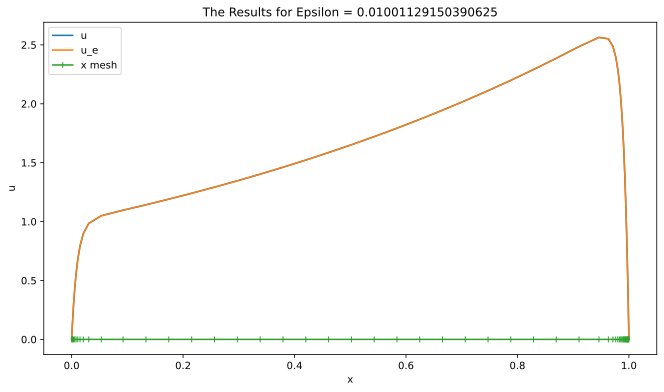



Epsilon continuation checks
norm(x) =  0.714862080497977
norm(u) =  1.589476486487008



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.007508468627929688
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.714862080497977
norm(u) =  1.589476486487008



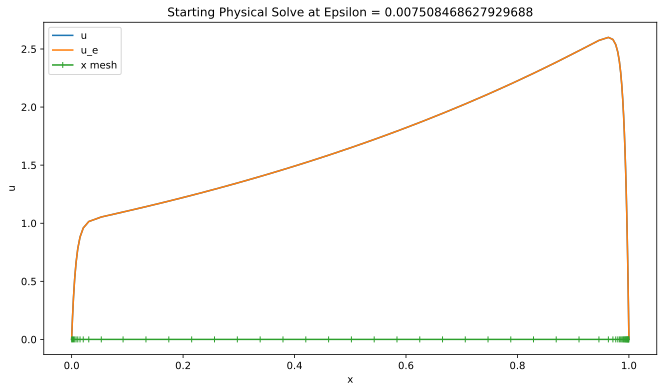



  0 SNES Function norm 9.409090954009e-01
  1 SNES Function norm 7.178566714885e-06
  0 SNES Function norm 7.876882832050e-01
  1 SNES Function norm 6.009584678195e-06
  0 SNES Function norm 6.271671063426e-01
  1 SNES Function norm 4.784905296951e-06
  0 SNES Function norm 5.014481841261e-01
  1 SNES Function norm 3.825746030809e-06
  0 SNES Function norm 4.527017133829e-01
  1 SNES Function norm 3.453839981712e-06
  0 SNES Function norm 4.840312759799e-01
  1 SNES Function norm 3.692865568470e-06
  0 SNES Function norm 5.419100707446e-01
  1 SNES Function norm 4.134445725979e-06
  0 SNES Function norm 5.749210013852e-01
  1 SNES Function norm 4.386299167463e-06
  0 SNES Function norm 5.713354316954e-01
  1 SNES Function norm 4.358943432970e-06
  0 SNES Function norm 5.472549556859e-01
  1 SNES Function norm 4.175223968075e-06
  0 SNES Function norm 5.139987720559e-01
  1 SNES Function norm 3.921499412247e-06
  0 SNES Function norm 4.687624856398e-01
  1 SNES Function norm 3.5763739

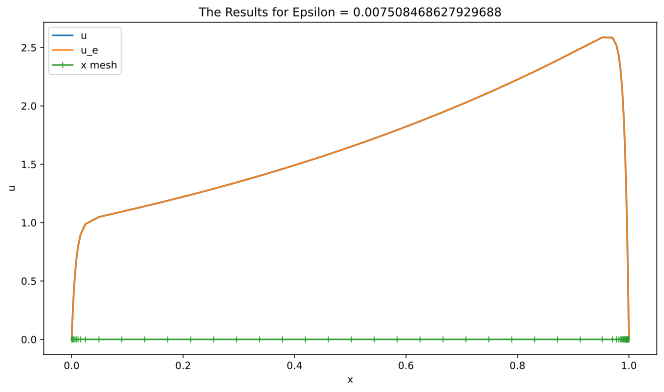



Epsilon continuation checks
norm(x) =  0.7165322169952377
norm(u) =  1.5981415987348773



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.005631351470947266
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7165322169952377
norm(u) =  1.5981415987348773



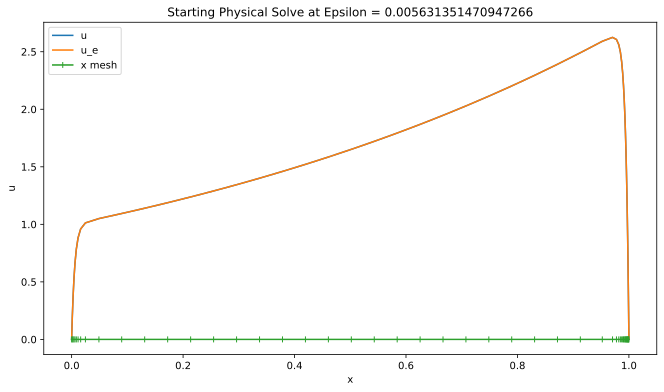



  0 SNES Function norm 1.066818087139e+00
  1 SNES Function norm 8.139176081348e-06
  0 SNES Function norm 9.038271966194e-01
  1 SNES Function norm 6.895654276512e-06
  0 SNES Function norm 7.226499471518e-01
  1 SNES Function norm 5.513381556471e-06
  0 SNES Function norm 5.748442043076e-01
  1 SNES Function norm 4.385713220587e-06
  0 SNES Function norm 5.096170187574e-01
  1 SNES Function norm 3.888069311739e-06
  0 SNES Function norm 5.508546718957e-01
  1 SNES Function norm 4.202687626744e-06
  0 SNES Function norm 6.553204263159e-01
  1 SNES Function norm 4.999698078737e-06
  0 SNES Function norm 7.427232474198e-01
  1 SNES Function norm 5.666528678311e-06
  0 SNES Function norm 7.605448259140e-01
  1 SNES Function norm 5.802496541114e-06
  0 SNES Function norm 7.102083499671e-01
  1 SNES Function norm 5.418459691798e-06
  0 SNES Function norm 6.303019018545e-01
  1 SNES Function norm 4.808821895060e-06
  0 SNES Function norm 5.548738179951e-01
  1 SNES Function norm 4.2333512

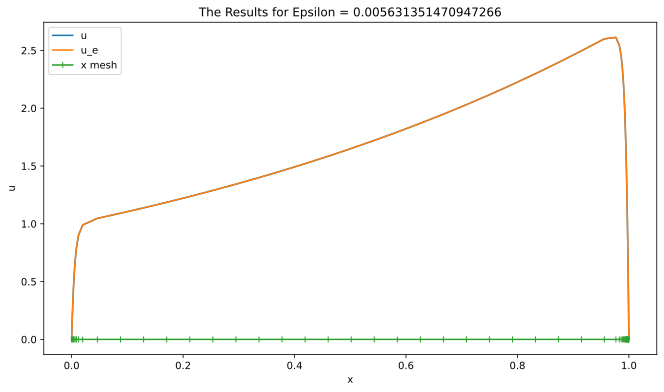



Epsilon continuation checks
norm(x) =  0.7178188279886496
norm(u) =  1.6048704737518729



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.004223513603210449
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7178188279886496
norm(u) =  1.6048704737518729



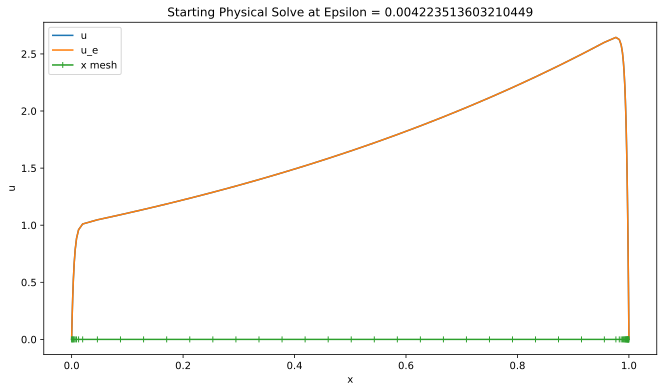



  0 SNES Function norm 1.116026812026e+00
  1 SNES Function norm 8.514608856141e-06
  0 SNES Function norm 9.650305062254e-01
  1 SNES Function norm 7.362598463979e-06
  0 SNES Function norm 8.031376416399e-01
  1 SNES Function norm 6.127453935991e-06
  0 SNES Function norm 6.621095329265e-01
  1 SNES Function norm 5.051494856707e-06
  0 SNES Function norm 5.739720794824e-01
  1 SNES Function norm 4.379059446195e-06
  0 SNES Function norm 5.932246581137e-01
  1 SNES Function norm 4.525944969371e-06
  0 SNES Function norm 7.223315766621e-01
  1 SNES Function norm 5.510952575660e-06
  0 SNES Function norm 8.862887420927e-01
  1 SNES Function norm 6.761846471758e-06
  0 SNES Function norm 9.942207623541e-01
  1 SNES Function norm 7.585302469139e-06
  0 SNES Function norm 9.940559125108e-01
  1 SNES Function norm 7.584044752667e-06
  0 SNES Function norm 8.947153154135e-01
  1 SNES Function norm 6.826136190789e-06
  0 SNES Function norm 7.436278725369e-01
  1 SNES Function norm 5.6734303

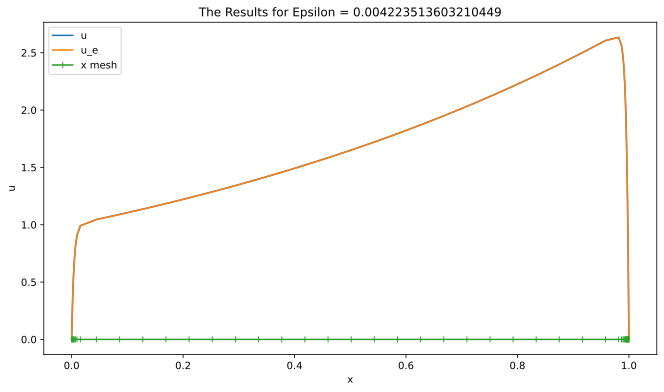



Epsilon continuation checks
norm(x) =  0.7188114772761066
norm(u) =  1.6098736019129827



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0031676352024078373
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7188114772761066
norm(u) =  1.6098736019129827



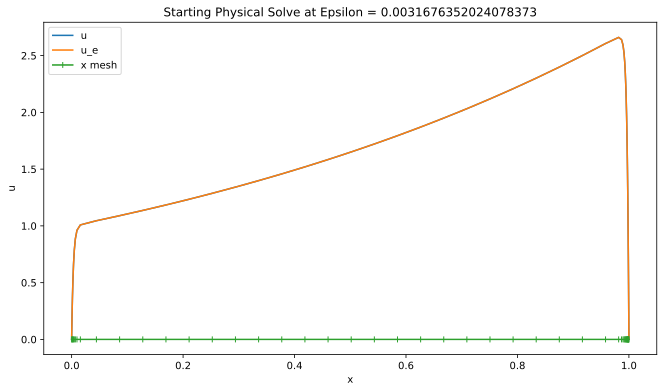



  0 SNES Function norm 1.121641748615e+00
  1 SNES Function norm 8.557447404561e-06
  0 SNES Function norm 1.020206200761e+00
  1 SNES Function norm 7.783555616359e-06
  0 SNES Function norm 9.199992237150e-01
  1 SNES Function norm 7.019037057108e-06
  0 SNES Function norm 7.961004325029e-01
  1 SNES Function norm 6.073764279337e-06
  0 SNES Function norm 6.810629950275e-01
  1 SNES Function norm 5.196098271242e-06
  0 SNES Function norm 6.475198165779e-01
  1 SNES Function norm 4.940184194332e-06
  0 SNES Function norm 7.425410863925e-01
  1 SNES Function norm 5.665138878488e-06
  0 SNES Function norm 9.369964068993e-01
  1 SNES Function norm 7.148715274185e-06
  0 SNES Function norm 1.140865746727e+00
  1 SNES Function norm 8.704114883590e-06
  0 SNES Function norm 1.258281654819e+00
  1 SNES Function norm 9.599927151095e-06
  0 SNES Function norm 1.237473874704e+00
  1 SNES Function norm 9.441176370136e-06
  0 SNES Function norm 1.092030116547e+00
  1 SNES Function norm 8.3315286

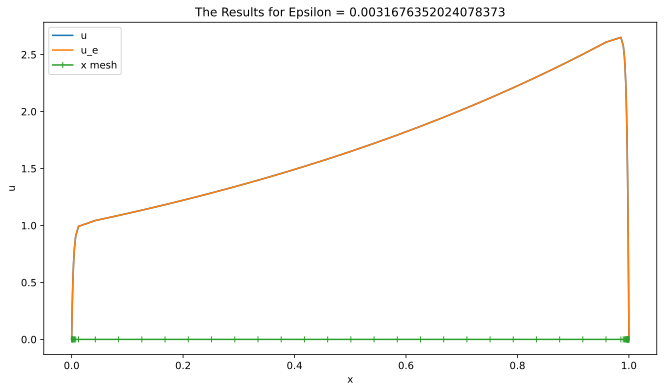



Epsilon continuation checks
norm(x) =  0.7193975270873536
norm(u) =  1.613188093939125



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.002375726401805878
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7193975270873536
norm(u) =  1.613188093939125



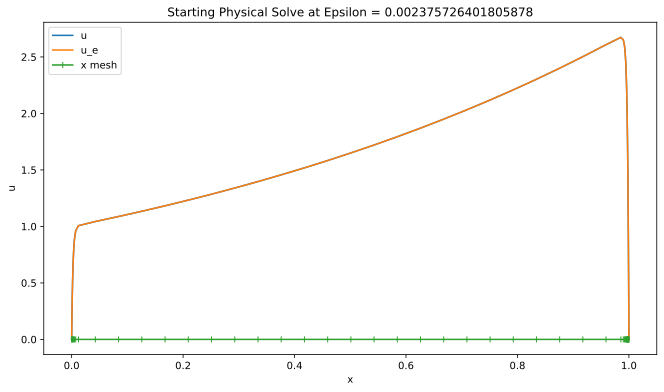



  0 SNES Function norm 1.132756120538e+00
  1 SNES Function norm 8.642243352089e-06
  0 SNES Function norm 1.114350109574e+00
  1 SNES Function norm 8.501816639183e-06
  0 SNES Function norm 1.072597630234e+00
  1 SNES Function norm 8.183270473550e-06
  0 SNES Function norm 9.647000487268e-01
  1 SNES Function norm 7.360077258456e-06
  0 SNES Function norm 8.267500403463e-01
  1 SNES Function norm 6.307602199605e-06
  0 SNES Function norm 7.463396618887e-01
  1 SNES Function norm 5.694119758591e-06
  0 SNES Function norm 7.786117071777e-01
  1 SNES Function norm 5.940335867070e-06
  0 SNES Function norm 9.366603518773e-01
  1 SNES Function norm 7.146151355471e-06
  0 SNES Function norm 1.180782705380e+00
  1 SNES Function norm 9.008657075687e-06
  0 SNES Function norm 1.411926031164e+00
  1 SNES Function norm 1.077214074768e-05
  0 SNES Function norm 1.535134887557e+00
  1 SNES Function norm 1.171214969248e-05
  0 SNES Function norm 1.506371363262e+00
  1 SNES Function norm 1.1492701

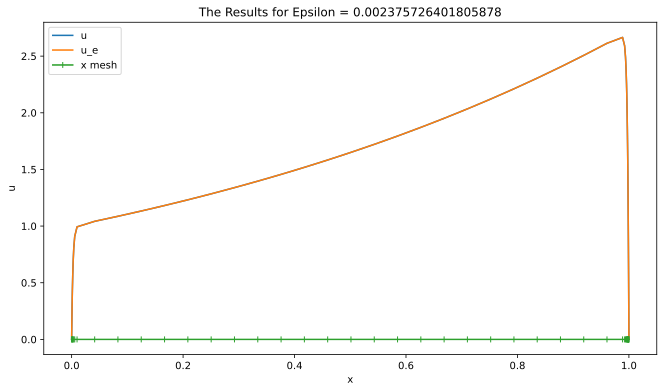



Epsilon continuation checks
norm(x) =  0.7200985730512435
norm(u) =  1.6169367560491659



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0017817948013544084
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7200985730512435
norm(u) =  1.6169367560491659



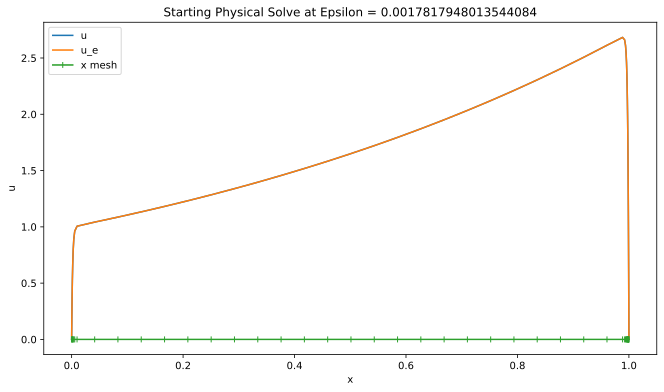



  0 SNES Function norm 1.177310810218e+00
  1 SNES Function norm 8.982168683777e-06
  0 SNES Function norm 1.218383882445e+00
  1 SNES Function norm 9.295531313868e-06
  0 SNES Function norm 1.231496066078e+00
  1 SNES Function norm 9.395569336231e-06
  0 SNES Function norm 1.140070485871e+00
  1 SNES Function norm 8.698047554342e-06
  0 SNES Function norm 9.783106540021e-01
  1 SNES Function norm 7.463917942716e-06
  0 SNES Function norm 7.793222153173e-01
  1 SNES Function norm 5.945756660943e-06
  0 SNES Function norm 8.133497914559e-01
  1 SNES Function norm 6.205366468353e-06
  0 SNES Function norm 9.779911306812e-01
  1 SNES Function norm 7.461480139550e-06
  0 SNES Function norm 1.113018212919e+00
  1 SNES Function norm 8.491655086668e-06
  0 SNES Function norm 1.361701170266e+00
  1 SNES Function norm 1.038895543729e-05
  0 SNES Function norm 1.606633355070e+00
  1 SNES Function norm 1.225763966879e-05
  0 SNES Function norm 1.735425426995e+00
  1 SNES Function norm 1.3240245

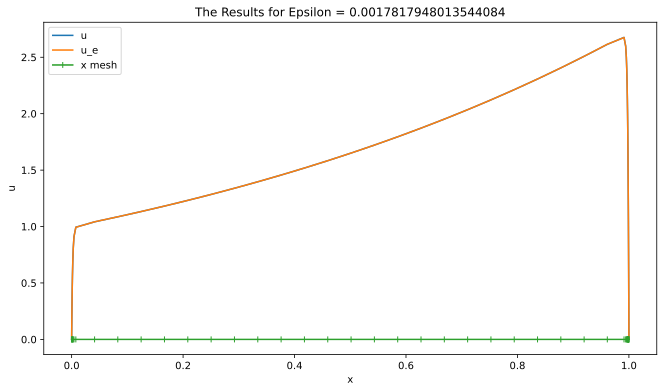



Epsilon continuation checks
norm(x) =  0.7205861083376465
norm(u) =  1.6188668613691803



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0013363461010158064
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7205861083376465
norm(u) =  1.6188668613691803



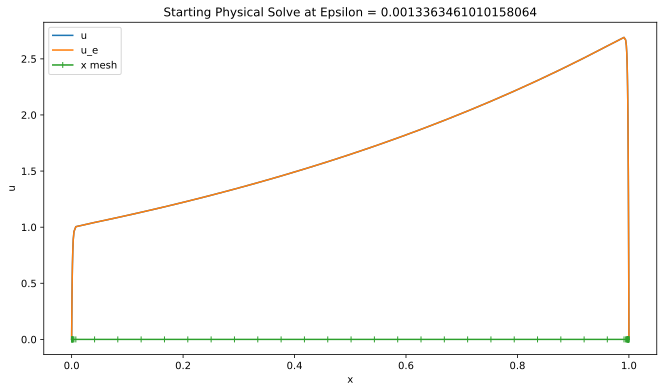



  0 SNES Function norm 1.212854635279e+00
  1 SNES Function norm 9.253346476614e-06
  0 SNES Function norm 1.318042612510e+00
  1 SNES Function norm 1.005586707214e-05
  0 SNES Function norm 1.382285814766e+00
  1 SNES Function norm 1.054600385759e-05
  0 SNES Function norm 1.313338270438e+00
  1 SNES Function norm 1.001997585623e-05
  0 SNES Function norm 1.015263190681e+00
  1 SNES Function norm 7.745843438977e-06
  0 SNES Function norm 8.236413507124e-01
  1 SNES Function norm 6.283884774536e-06
  0 SNES Function norm 8.081484468070e-01
  1 SNES Function norm 6.165683417775e-06
  0 SNES Function norm 9.753756927287e-01
  1 SNES Function norm 7.441525990094e-06
  0 SNES Function norm 1.240651381143e+00
  1 SNES Function norm 9.465418881897e-06
  0 SNES Function norm 1.417818887161e+00
  1 SNES Function norm 1.081709964781e-05
  0 SNES Function norm 1.414877177649e+00
  1 SNES Function norm 1.079465621463e-05
  0 SNES Function norm 1.653232020565e+00
  1 SNES Function norm 1.2613159

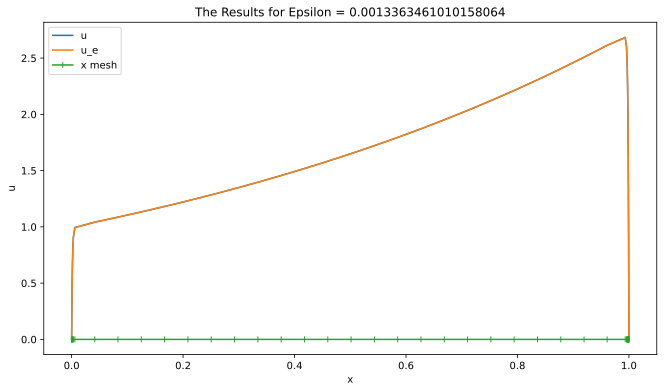



Epsilon continuation checks
norm(x) =  0.7208589735930938
norm(u) =  1.6193506554800738



-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_
EPSILON =  0.0010022595757618548
-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_


Epsilon continuation checks
norm(x) =  0.7208589735930938
norm(u) =  1.6193506554800738



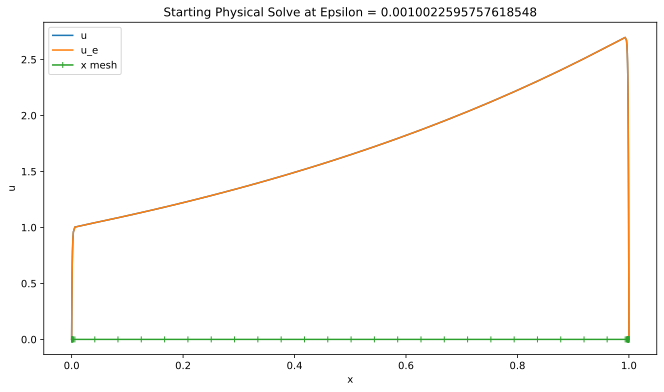



  0 SNES Function norm 1.257469898101e+00
  1 SNES Function norm 9.593734021367e-06
  0 SNES Function norm 1.409964399415e+00
  1 SNES Function norm 1.075717466708e-05
  0 SNES Function norm 1.511949855018e+00
  1 SNES Function norm 1.153526193080e-05
  0 SNES Function norm 1.453028267224e+00
  1 SNES Function norm 1.108572589154e-05
  0 SNES Function norm 1.144192338185e+00
  1 SNES Function norm 8.729494752811e-06
  0 SNES Function norm 9.436376271159e-01
  1 SNES Function norm 7.199383682202e-06
  0 SNES Function norm 8.464480179580e-01
  1 SNES Function norm 6.457885910608e-06
  0 SNES Function norm 9.026427579252e-01
  1 SNES Function norm 6.886617645213e-06
  0 SNES Function norm 1.153792322862e+00
  1 SNES Function norm 8.802736807767e-06
  0 SNES Function norm 1.507486677002e+00
  1 SNES Function norm 1.150121061724e-05
  0 SNES Function norm 1.747866356540e+00
  1 SNES Function norm 1.333516208777e-05
  0 SNES Function norm 1.675281733376e+00
  1 SNES Function norm 1.2781385

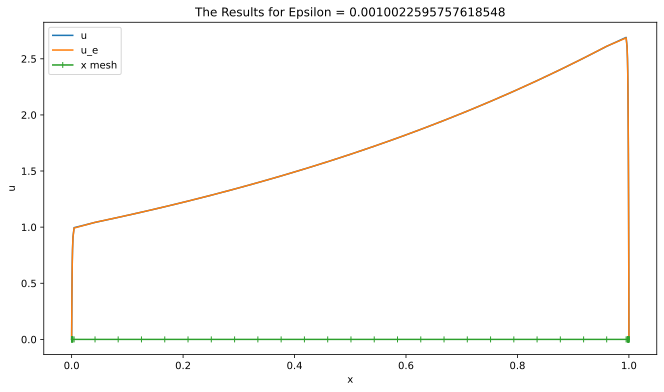



Epsilon continuation checks
norm(x) =  0.720941229548164
norm(u) =  1.6188945541315494



In [5]:
# SET EPSILONS
epsilon = 0.1
eps_final = 1e-3
eps_change = 3/4
results = []

# PICARD DAMPING
w = 1/2

# MP STOPPING CRITERIA
mesh_tol = 1e-8
max_MP_iters = 100


# FUNCTIONS TO SAVE RESULTS
u_save = Function(V_phys)
x_save = Function(V_mesh)


# M PARAMETERS (m=0 IS L2)
p = 2
q = 2
m = 0
exp_M = Constant( (2*q) / (1 + q*(2-m)) )
alpha_power = -3/4
alpha_scale = 5


# SET EXACT U
top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
sub = exp(x)/(epsilon**2 - 1)
u_e = top/bottom - sub



# INITIAL GUESSES
x = Function(V_mesh).interpolate(SpatialCoordinate(xi_mesh)[0])
u = Function(V_phys).interpolate(x + 1/2)


# EPSILON CONTINUATION
##########################################################


while epsilon >= eps_final:


    print()
    print()
    print('-_'*100)
    print('EPSILON = ', epsilon)
    print('-_'*100)
    print()
    print()


    mesh_convergence = False
    mesh_norms = []
    mesh_residuals = []
    MP_Iter = 0

    # continuation checks
    print('Epsilon continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()


    # STARTING PHYSICAL SOLVE AT NEW EPSILON ON OLD MESH

    # Test and Trial Functions
    u_new = TrialFunction(V_phys)
    v = TestFunction(V_phys)

    # Jacobian of x
    Jx = x.dx(0) #dx/dxi

    # Set the bilinear and linear forms of the weak form
    u_deriv = (1/Jx) * u_new.dx(0) # transform to du/dx
    v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
    a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u_new, v)) * Jx * dx # transform dxi to dx
    L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

    # Set the BC's
    bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

    # Solve
    try:
      u_new = Function(V_phys).interpolate(u)
      solve( a==L, u_new, bcs = bcs, solver_parameters = lu_params)
    except Exception as e:
      print('The physical solve failed due to the following message:')
      print(e)
      print()

    # Update u
    u.dat.data[:] = u_new.dat.data[:]



    # exact u
    top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
    bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
    sub = exp(x)/(epsilon**2 - 1)
    u_e = top/bottom - sub

    # plot
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u_e).dat.data[perm_x], label = 'u_e')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Starting Physical Solve at Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()



    # MP ITERATION
    ##############################################################



    while not(mesh_convergence):

        MP_Iter += 1



        # Check Max iterations
        if MP_Iter > max_MP_iters:
          print()
          print('MAX MP ITERATIONS REACHED SO WE BREAK!')
          print('THE LAST 5 MESH NORMS ARE:', end = "  ")
          print(mesh_norms[-5:])
          print()
          break




        # MESH DENSITY FUNCTION



        # Compute u'
        Jx = x.dx(0)
        upr_f = (1/Jx) * u.dx(0)
        # Compute u''
        u_pr_xi = u.dx(0)
        u_prpr_xi = u_pr_xi.dx(0)
        x_prpr_xi = Jx.dx(0)
        u_prpr = ( u_prpr_xi -  upr_f * x_prpr_xi) * (( 1/Jx )**2)

        # Compute M
        alpha_hat = alpha_scale * epsilon ** (alpha_power)
        # alpha_term1 = float(alpha_hat * sqrt(assemble(u_e*u_e* Jm * dx)))
        M = ( 1 + (1/alpha_hat) * abs(u_prpr) )**exp_M



        # MESH RESIDUAL
        vr = TestFunction(V_mesh)
        residual = Cofunction(V_mesh.dual())
        assemble(inner(M * x.dx(0), vr.dx(0))*dx, tensor=residual)
        mesh_residuals.append(norm(residual.riesz_representation()))



        # LINEAR MESH SOLVE




        # set solution and test function
        new_x = Function(V_mesh)
        vm = TestFunction(V_mesh)


        # jacobian
        Jm = new_x.dx(0) #dx/dxi

        # v'
        v_pr_term = (vm).dx(0)

        # the lhs of the eqn
        F = (M * Jm * v_pr_term) * dx




        # bc's
        bc0 = DirichletBC(V_mesh, Constant(0), 1)
        bc1 = DirichletBC(V_mesh, Constant(1), 2)
        bcs = [bc0, bc1]

        # initial guess
        new_x.dat.data[:] = x.dat.data[:]

        # The actual solve
        try:
          solve( F == 0, new_x, bcs = bcs, solver_parameters=mesh_params)
        except Exception as e:
          print('MESH SOLVE FAILED BECAUSE ', e)
          print()
          print()
          break


        # check mesh convergence
        mesh_norm = errornorm(new_x, x)
        mesh_norms.append(mesh_norm)

        if mesh_norm <= mesh_tol: # then the meshes have converged
          print()
          print('SINCE MESH TOLERANCE = ', mesh_norm, "WE HAVE MESH CONVERGENCE IN", MP_Iter, "MP ITERATIONS")
          print()
          mesh_convergence = True



        # update our x
        x.interpolate( (1-w) * x + w * new_x)




        # LINEAR PHYSICAL SOLVE




        # Test and Trial Functions
        u_new = TrialFunction(V_phys)
        v = TestFunction(V_phys)

        # Jacobian of x
        Jx = x.dx(0) #dx/dxi

        # Set the bilinear and linear forms of the weak form
        u_deriv = (1/Jx) * u_new.dx(0) # transform to du/dx
        v_deriv = (1/Jx) * v.dx(0) # transform to dv/dx
        a = ((epsilon**2)* (u_deriv * v_deriv ) + inner(u_new, v)) * Jx * dx # transform dxi to dx
        L = ( exp(x) ) * v * Jx * dx #transform dxi to dx

        # Set the BC's
        bcs = [DirichletBC(V_phys, Constant(0), 1), DirichletBC(V_phys, Constant(0), 2)]

        # Solve
        try:
          u_new = Function(V_phys).interpolate(u)
          solve( a==L, u_new, bcs = bcs, solver_parameters = lu_params)
        except Exception as e:
          print('The physical solve failed due to the following message:')
          print(e)
          print()
          break

        # Update u
        u.dat.data[:] = u_new.dat.data[:]




    # L2 AND ENERGY NORM FOR RESULT OF CURRENT EPSILON



    print()
    print('_'*100)
    print('RESULTS')
    print('_'*100)
    print()


    print("MESH RESIDUALS:")
    for r in mesh_residuals:
      print(r, end = ", ")
    print()
    print()


    print("ERRORS:")

    # Exact Solution
    top = (1 - exp(1 - 1/epsilon))*exp(-x/epsilon) + (exp(1) - exp(-1/epsilon))*exp((x-1)/epsilon)
    bottom = (epsilon**2 - 1) * ( 1 - exp(-2/epsilon) )
    sub = exp(x)/(epsilon**2 - 1)
    u_e = top/bottom - sub

    # L^2 error
    Jx = x.dx(0)
    error_val = (u - u_e)
    L2_error = norm(error_val * (sqrt(abs(Jx))))
    print("L2 error is", L2_error)

    # Energy norm error
    # (\eps^2 || u' ||_0^2 + || u ||_0^2 ) ^{1/2}
    u_approx_pr = (1/Jx) * u.dx(0)
    u_exact_pr = (1/Jx) * u_e.dx(0)
    u_pr_error = (u_approx_pr - u_exact_pr)
    L2_pr = norm(u_pr_error * (sqrt(abs(Jx))))
    energy_error =  float(sqrt( (epsilon**2) * (L2_pr**2) + (L2_error**2) ))
    print("Energy norm error is", energy_error)
    print()



    # SAVE AND PLOT THE RESULTS FOR THE CURRENT EPSILON

    # save
    u_save.dat.data[:] = u.dat.data[:]
    x_save.dat.data[:] = x.dat.data[:]
    results.append([epsilon, L2_error, energy_error, u_save, x_save])

    print('PLOTS:')

    # plot
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u).dat.data[perm_x], label = 'u')
    plt.plot(x.dat.data[perm_x], Function(V_mesh).interpolate(u_e).dat.data[perm_x], label = 'u_e')
    plt.plot(x.dat.data[perm_x], [0 for i in range(len(x.dat.data[perm_x]))], marker = '|', label = 'x mesh')
    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('The Results for Epsilon = ' + str(epsilon))
    plt.legend()
    plt.show()
    print()
    print()


    # UPDATE EPSILON
    epsilon = epsilon * eps_change


    # continuation checks
    print('Epsilon continuation checks')
    print("norm(x) = ", norm(x))
    print("norm(u) = ", norm(u))
    print()


